In [13]:
from abc import abstractmethod, ABC
from typing import Callable, Tuple
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427

In [14]:
# @staticmethod
#     def _heavyside(z):
#         return np.where(z >= 0, 1, 0)
#
#     @staticmethod
#     def _sin(z):
#         return np.sin(z)
#
#     @staticmethod
#     def _tanh(z):
#         return np.tanh(z)
#
#     @staticmethod
#     def _sign(z):
#         return np.sign(z)
#
#     @staticmethod
#     def _relu(z):
#         return np.maximum(0, z)
#
#     @staticmethod
#     def _leaky_relu(z):
#         return np.maximum(0.01 * z, z)
#
#     @staticmethod
#     def _sigmoid(z):
#         return 1 / (1 + np.exp(-z))
#
#     @staticmethod
#     def _heavyside_derivative(z):
#         return np.ones_like(z)
#
#     @staticmethod
#     def _sin_derivative(z):
#         return np.cos(z)
#
#     @staticmethod
#     def _tanh_derivative(z):
#         return 1 / (np.cosh(z) ** 2)
#
#     @staticmethod
#     def _sign_derivative(z):
#         return np.ones_like(z)
#
#     @staticmethod
#     def _relu_derivative(z):
#         return np.where(z >= 0, 1, 0)
#
#     @staticmethod
#     def _leaky_relu_derivative(z):
#         return np.where(z >= 0, 1, 0.01)
#
#     @staticmethod
#     def _sigmoid_derivative(z):
#         return MyLogisticRegression._sigmoid(z) * (1 - MyLogisticRegression._sigmoid(z))
#
#
# self.activation_function = \
#             {'Heavyside': self._heavyside,
#              'sin': self._sin,
#              'tanh': self._tanh,
#              'sign': self._sign,
#              'Relu': self._relu,
#              'LeakyRelu': self._leaky_relu,
#              'sigmoid': self._sigmoid}[activation]
#
#         self.activation_derivative = \
#             {'Heavyside': self._heavyside_derivative,
#              'sin': self._sin_derivative,
#              'tanh': self._tanh_derivative,
#              'sign': self._sign_derivative,
#              'Relu': self._relu_derivative,
#              'LeakyRelu': self._leaky_relu_derivative,
#              'sigmoid': self._sigmoid_derivative}[activation]

In [15]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float]:
                continue

            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float] or len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

            self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

In [16]:
class ActivationFunction(ABC):
    threshold = 0
    @abstractmethod
    def __call__(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    @abstractmethod
    def derivative(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    def d(self, x: ndarray) -> ndarray:
        return self.derivative(x)


In [32]:
class MyNeuron:
    _accepted_activation_functions = ['Heaviside', 'sin', 'tanh', 'sign', 'Relu', 'LeakyRelu', 'sigmoid']

    class _Heaviside(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, 1, 0)

        def derivative(self, x: ndarray) -> ndarray:
            return np.ones_like(x)

    class _Sin(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.sin(x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.cos(x)

    class _Tanh(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.tanh(x)

        def derivative(self, x: ndarray) -> ndarray:
            return 1 / (np.cosh(x) ** 2)

    class _Sign(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.sign(x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.ones_like(x)

    class _Relu(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, x, 0)

        def derivative(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, 1, 0)

    class _LeakyRelu(ActivationFunction):
        threshold = 0.01
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, x, 0.01 * x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, 1, 0.01)

    class _Sigmoid(ActivationFunction):
        threshold = 0.5
        def __call__(self, x: ndarray) -> ndarray:
            return 1 / (1 + np.exp(-x))

        def derivative(self, x: ndarray) -> ndarray:
            return self(x) * (1 - self(x))

    @staticmethod
    def expand_features(X: ndarray) -> ndarray:
        return np.c_[np.ones(X.shape[0])*-1, X]

    def __init__(self, lr: float = 0.05, min_lr: float = 0.01, max_lr: float = 0.1, activation: str= 'Relu', batch_size: int=8, epochs: int = 100, verbose: bool = True):
        if activation not in self._accepted_activation_functions:
            raise ValueError(f'Activation function {activation} is not supported')

        self.learning_rate = lr
        self.min_learning_rate = min_lr
        self.max_learning_rate = max_lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.coef_ = None
        self.activation = {'Heaviside': self._Heaviside(),
                           'sin': self._Sin(),
                           'tanh': self._Tanh(),
                           'sign': self._Sign(),
                           'Relu': self._Relu(),
                           'LeakyRelu': self._LeakyRelu(),
                           'sigmoid': self._Sigmoid()}[activation]

    def fit(self, X, Y):
        X = self.expand_features(X)
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc=1, scale=.15, size=(1, X.shape[1]))

        Y = Y.reshape(-1, 1)
        n = X.shape[0]
        batch_divisible = n - n % self.batch_size

        for e in tqdm(range(self.epochs), disable=not self.verbose):
            indexes = np.arange(0, n, 1)
            np.random.shuffle(indexes)
            batched_X = X[indexes]
            batched_Y = Y[indexes]

            batched_X = batched_X[:batch_divisible]
            batched_Y = batched_Y[:batch_divisible]

            for i in range(0, batch_divisible, self.batch_size):
                X_batch = batched_X[i:i+self.batch_size]
                Y_batch = batched_Y[i:i+self.batch_size]
                preds = self.activation(np.dot(X_batch, self.coef_.T))

                dW = (Y_batch - preds) * self.activation.d(X_batch.dot(self.coef_.T)) * X_batch
                self.coef_ += self.learning_rate * dW.mean(axis=0)

            self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate) * (1 + np.cos(e / self.epochs * np.pi))

        return self

    def decision_function(self, X):
        X = self.expand_features(X)
        return self.activation(X.dot(self.coef_.T))

    def predict(self, X):
        return np.where(self.decision_function(X) > self.activation.threshold, 1, 0)


In [38]:
def display_neuron_with_activation_and_batch_size(data: PUMData, activation = 'Relu', batch_size=8, epochs=100, n_trains=100):

    print(f'Training {n_trains} times with activation {activation} and batch size {batch_size}')
    start = time()
    for _ in tqdm(range(n_trains)):
        model = MyNeuron(activation=activation, batch_size=batch_size, verbose=False, epochs=epochs)
        model.fit(data.x_train, data.y_train)
    end = time()

    model = MyNeuron(activation=activation, batch_size=batch_size, epochs=epochs)
    model.fit(data.x_train, data.y_train)

    f, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 10))
    f.suptitle(f'Neuron {activation}, batch size {batch_size}, epochs {epochs}\n'
               f'Average time of training: {(end - start) / n_trains}')

    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_data).reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4, levels=1)
    ax[0].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")


    predictions = model.predict(data.x_test)
    cm = confusion_matrix(data.y_test, predictions, labels=[0, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    sns.heatmap(cm, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title(f'Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, predictions, adjusted=True)}')

    decision_function = model.decision_function(data.x_test)
    fpr, tpr, thresholds = roc_curve(data.y_test, decision_function)
    ax[2].plot(fpr, tpr, label=f'Model, AUC={roc_auc_score(data.y_test, decision_function):.3f}')


In [34]:
single_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state))

Training 5 times with activation sigmoid and batch size 8


100%|██████████| 100/100 [00:00<00:00, 142.88it/s]


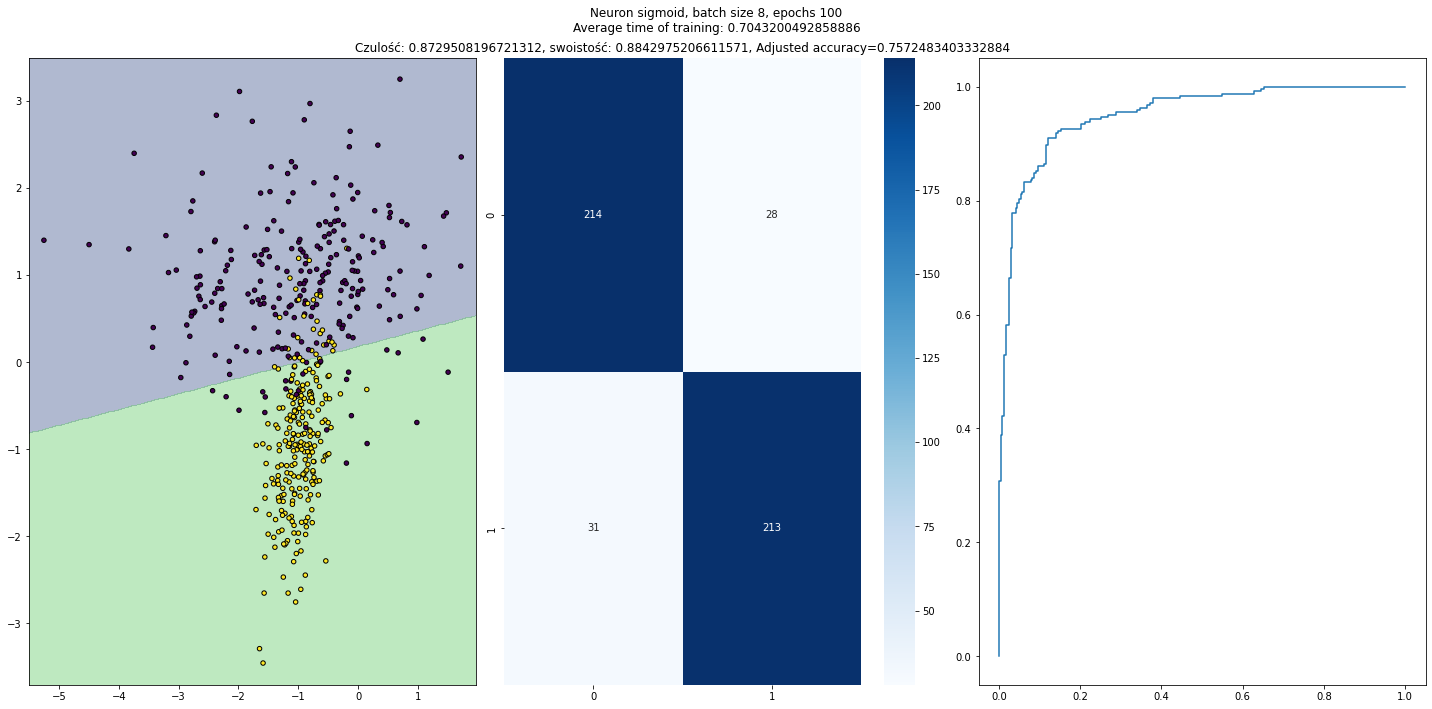

In [39]:
display_neuron_with_activation_and_batch_size(single_mod_data, activation='sigmoid', batch_size=8, epochs=100, n_trains=5)